# For a given day, plot SMAP L2 and L3 maps in the Beaufort Sea

Still in development, use with care!

Cloud access.
Uses the earthdata library developed by Luis Lopez at PO.DAAC.

In [4]:
import os
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import h5netcdf # needed for hdf5 format netcdf files
import glob as glob

from datetime import datetime

# plotting packages
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker

# Earthdata
#  - DataCollections is a library that allows us to search collections
#  - DataGranules is a library that allows us to search granules
from earthdata import DataCollections, DataGranules, Auth, Store

In [23]:
# define date and domain of interest
start_date = "2021-09-01T00:00:00"
end_date = "2021-09-01T23:59:59" # one day 

# many days
start_date = "2021-09-01T00:00:00"
end_date = "2021-09-15T23:59:59" 

date_range = start_date + "/" + end_date # this format is needed for 'requests'
print(date_range)

# beaufort sea - use -180:180 longitude convention
lonrange = [-160, -130]
latrange = [68, 80]
# bounding_box = (f'{lonrange[0]},{latrange[0]},{lonrange[1]},{latrange[1]}') # make this a string
# not a string
bounding_box = (lonrange[0], latrange[0], lonrange[1], latrange[1])


# local data folder
#datadir = '/data1/sassie/satellite/' # kyla's computer
# datadir = '~/Data/raw/sassie/satellite/' #Severine's computer
datadir = './data/' # generic local folder

2021-09-01T00:00:00/2021-09-15T23:59:59


### L3 SMAP SSS. 

#### We are going to use [earthdata](https://github.com/nsidc/earthdata) to interact with CMR

First we initialize Auth() to get the cloud credentials, if we have a `.netrc` file this can be done automatically
The user's .netrc file includes a PO.DAAC tools password, which is accessed here: https://podaac-tools.jpl.nasa.gov/drive/

machine podaac-tools.jpl.nasa.gov \
login USERNAME\
password YOUR_PW


In [5]:
auth = Auth().login(strategy='netrc')
if auth.authenticated is None:
    # we ask for credentials
    auth.login()

You're now authenticated with NASA Earthdata Login


In [6]:
# dataset info
# The earthdata library works with the dataset shortname.
# (note that JPL and RSS use different conventions for lat/lon, so code will have to be generalized if both products are desired)

ShortName_sss = "SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5"

# See: https://github.com/nsidc/earthdata
CollectionQuery = DataCollections().short_name(ShortName_sss).cloud_hosted(True)
collections = CollectionQuery.get()

for collection in collections:
    concept_id = collection.concept_id()
    print(concept_id)

C2208422957-POCLOUD


In [10]:
# create a local folder for the data if it doesn't exist
savedir = f'{datadir}smap/L3/'
os.makedirs(savedir, exist_ok=True)

In [27]:
# dates to load:
days = pd.date_range(start=pd.to_datetime(start_date).round('D'),
              end=pd.to_datetime(end_date).round('D'))
days = days.values

# we use a Set to avoid repeating queries to the same day
# can probably skip this but it's leftover from Luis' code
date_ranges = set()
for day in days:
    start_date = str(day)
    end_date = str(day + np.timedelta64(1, 'D'))
    # or end_date = str(day + np.timedelta64(1, 'D') - np.timedelta64(1, 's')) for 23:59:59 of the same day, the 
    # search on CMR is the same.
    date_range = (start_date, end_date)
    date_ranges.add(date_range)
date_ranges


{('2021-09-01T00:00:00.000000000', '2021-09-02T00:00:00.000000000'),
 ('2021-09-02T00:00:00.000000000', '2021-09-03T00:00:00.000000000'),
 ('2021-09-03T00:00:00.000000000', '2021-09-04T00:00:00.000000000'),
 ('2021-09-04T00:00:00.000000000', '2021-09-05T00:00:00.000000000'),
 ('2021-09-05T00:00:00.000000000', '2021-09-06T00:00:00.000000000'),
 ('2021-09-06T00:00:00.000000000', '2021-09-07T00:00:00.000000000'),
 ('2021-09-07T00:00:00.000000000', '2021-09-08T00:00:00.000000000'),
 ('2021-09-08T00:00:00.000000000', '2021-09-09T00:00:00.000000000'),
 ('2021-09-09T00:00:00.000000000', '2021-09-10T00:00:00.000000000'),
 ('2021-09-10T00:00:00.000000000', '2021-09-11T00:00:00.000000000'),
 ('2021-09-11T00:00:00.000000000', '2021-09-12T00:00:00.000000000'),
 ('2021-09-12T00:00:00.000000000', '2021-09-13T00:00:00.000000000'),
 ('2021-09-13T00:00:00.000000000', '2021-09-14T00:00:00.000000000'),
 ('2021-09-14T00:00:00.000000000', '2021-09-15T00:00:00.000000000'),
 ('2021-09-15T00:00:00.000000000',

#### We query CMR for the granules we want

Since `SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5` is an **8-day running mean** a query to a given day will overlap with 
8 different days and we are only interested in the mid date.

An important thing to notice is that `earthdata` encodes CMR responses in a data granule class, this class is just an extended Python dictionary but all the values are still accesible using the UMM fields. 

```python
# metadata values
granule["meta"]
# granule temporal extend
granule["umm"]["TemporalExtent"]
```

we can even print the whole record with `print(granule)` or `pprint(granule)`

In [28]:
from dateutil.parser import parse

matching_granules = {"cloud-only": [],
                     "cloud-external": []}  # dict of granules to load

for dt in date_ranges:
    download_size = 0
    GranuleQuery = DataGranules().parameters(
        concept_id=concept_id,
        bounding_box=bounding_box,
        temporal=dt)
    granules = GranuleQuery.get()
    # Since our query at this point is for one day only
    dt_middate = parse(str(dt[0])).strftime('%Y%m%d')
    for granule in granules:
        # The native_id has the mid_date encoded in this case
        if dt_middate in granule["meta"]["native-id"]:
            matching_granules["cloud-only"].extend(granule.data_links(s3_only=True))
            # This is a workaround, eathdata should have a way to get the onprem links.
            matching_granules["cloud-external"].extend([granule.data_links()[0]])
            download_size += granule.size()
print(f"total granules: {len(matching_granules['cloud-external'])}, size(MB): {round(download_size, 2)}")




total granules: 16, size(MB): 10.82


In [29]:
matching_granules

{'cloud-only': ['s3://podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/249/SMAP_L3_SSS_20210910_8DAYS_V5.0.nc',
  's3://podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/245/SMAP_L3_SSS_20210906_8DAYS_V5.0.nc',
  's3://podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/240/SMAP_L3_SSS_20210901_8DAYS_V5.0.nc',
  's3://podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/248/SMAP_L3_SSS_20210909_8DAYS_V5.0.nc',
  's3://podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/247/SMAP_L3_SSS_20210908_8DAYS_V5.0.nc',
  's3://podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/255/SMAP_L3_SSS_20210916_8DAYS_V5.0.nc',
  's3://podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/241/SMAP_L3_SSS_20210902_8DAYS_V5.0.nc',
  's3://podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/243/SMAP_L3_SSS_20210904_8DAYS_V5.0.nc',
  

### We use earthdata to get a S3FS session for the PODAAC cloud data
> NOTE: This session is valid for 1 hour

In [30]:
# IMPORTANT: This session will be valid for 1 hour
fs = Store(auth).get_s3fs_session('POCLOUD')
fs

# Opening the files directly in S3!
> NOTE: depending on the number of granules this operation will take longer than downloading the granules to our cloud VM. 

We are opening the files via s3fs and xarray is doing a subsetting on-the-fly, this is possible because we're working with L3 data in a format xarray understands. 

In [31]:
%%time
# we open the files in the cloud and pass the S3FS fileset to xarray
fileset = [fs.open(s3_granule )for s3_granule in matching_granules["cloud-only"]]

ds_smap_L3 = xr.open_mfdataset(
    fileset,
    combine='nested',
    concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}
    ).sel(longitude=slice(lonrange[0],lonrange[1]), latitude=slice(latrange[1],latrange[0]))
ds_smap_L3

CPU times: user 9.75 s, sys: 2.7 s, total: 12.4 s
Wall time: 34.6 s


<xarray.Dataset>
Dimensions:               (time: 16, latitude: 48, longitude: 120)
Coordinates:
  * latitude              (latitude) float32 79.88 79.62 79.38 ... 68.38 68.12
  * longitude             (longitude) float32 -159.9 -159.6 ... -130.4 -130.1
  * time                  (time) datetime64[ns] 2021-09-10T12:00:00 ... 2021-...
Data variables:
    smap_sss              (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    anc_sss               (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    anc_sst               (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    smap_spd              (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    smap_high_spd         (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    weight                (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    land_fraction         (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    ice_fraction          (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
    smap_sss_uncertainty  (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 120), meta=np.ndarray>
Attributes: (12/40)
    title:                       SMAP 0.25x0.25 deg grid averaged 8-day SSS/WSPD
    institution:                 Jet Propulsion Laboratory
    source:                      SMAP L2B SSS
    history:                     DATA_SOURCE_VERSION V5.0 L2B SMAP SSS/WSPD
    comment:                     Gaussian-weighted map gridding of SMAP L2B S...
    Gaussian_window_radius:      45.0
    ...                          ...
    creator_name:                JPL
    creator_email:               fore@jpl.nasa.gov
    publisher_name:              Alexander G. Fore
    publisher_email:             fore@jpl.nasa.gov
    contributor_name:            Alexander Fore, Simon Yueh, Wenqing Tang, Ak...
    references:                  10.1109/TGRS.2016.2601486, 10.1109/TGRS.2016...

In [ ]:
# load all files & slice to our region

# note that JPL product uses "latitude" and "longitude" 
# and the lat is from +90 to -90 so the "sel" must go from latrange[1] to latrange[0]
# (RSS uses "lat" and "lon")

# ds_smap_L3 = xr.open_mfdataset(granules_load, engine='netcdf4').sel(longitude=slice(lonrange[0],lonrange[1]), latitude=slice(latrange[1],latrange[0]))
# ds_smap_L3

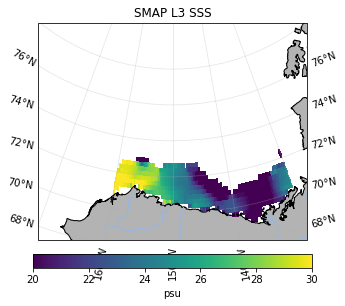

In [32]:
# plot one time
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(projection=map_proj)

tplot = ds_smap_L3.time[0]

sss_L3_img = ax1.pcolormesh(ds_smap_L3.longitude, ds_smap_L3.latitude, ds_smap_L3.sel(time=tplot).smap_sss, 
                        vmin=20, vmax=30,  # Set max and min values for plotting
                        cmap='viridis', shading='auto',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS 


#  ----- map stuff
ax1.coastlines(color='none')  # coastline
ax1.set_extent([-170, -130,68, 80], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
ax1.set_title('SMAP L3 SSS')
plt.colorbar(sss_L3_img, ax=ax1, orientation="horizontal", pad=0.05).set_label('psu')
# land color
ax1.add_feature(cartopy.feature.LAND , facecolor=(.7,.7,.7))
ax1.coastlines('10m')
ax1.add_feature(cartopy.feature.RIVERS)
# ticks
gl.ylocator = mticker.FixedLocator([68, 70, 72, 74, 76, 78])
gl.xlocator = mticker.FixedLocator([-170, -160, -150, -140, -130])
gl.top_labels = False
gl.bottom_labels = True



### L2 SMAP SSS

Cload-enabled dataset ..... can we use earthdata for L2 data?!?!


In [33]:
# dataset info
# The earthdata library works with the dataset shortname.
# (note that JPL and RSS use different conventions for lat/lon, so code will have to be generalized if both products are desired)

ShortName_sss = "SMAP_JPL_L2B_SSS_CAP_V5"

# See: https://github.com/nsidc/earthdata
CollectionQuery = DataCollections().short_name(ShortName_sss).cloud_hosted(True)
collections = CollectionQuery.get()

for collection in collections:
    concept_id = collection.concept_id()
    print(concept_id)

C2208420167-POCLOUD


In [ ]:
# download the granules
# create a local folder for the data if it doesn't exist
savedir = f'{datadir}smap/L2/'
os.makedirs(savedir, exist_ok=True)


In [34]:
# copy the code from L3 above
from dateutil.parser import parse

matching_granules = {"cloud-only": [],
                     "cloud-external": []}  # dict of granules to load

for dt in date_ranges:
    download_size = 0
    GranuleQuery = DataGranules().parameters(
        concept_id=concept_id,
        bounding_box=bounding_box,
        temporal=dt)
    granules = GranuleQuery.get()
    # Since our query at this point is for one day only
    dt_middate = parse(str(dt[0])).strftime('%Y%m%d')
    for granule in granules:
        # The native_id has the mid_date encoded in this case
        if dt_middate in granule["meta"]["native-id"]:
            matching_granules["cloud-only"].extend(granule.data_links(s3_only=True))
            # This is a workaround, eathdata should have a way to get the onprem links.
            matching_granules["cloud-external"].extend([granule.data_links()[0]])
            download_size += granule.size()
print(f"total granules: {len(matching_granules['cloud-external'])}, size(MB): {round(download_size, 2)}")


total granules: 225, size(MB): 275.97


In [37]:
%%time
fileset = [fs.open(s3_granule )for s3_granule in matching_granules["cloud-only"]]
# ds_smap_L2 = xr.open_mfdataset(
#     fileset,
#     combine='nested',
#     concat_dim='time',
#     decode_cf=True,
#     coords='minimal',
#     chunks={'time': 1}
#     ).sel(longitude=slice(lonrange[0],lonrange[1]), latitude=slice(latrange[1],latrange[0]))
# ds_smap_L2

CPU times: user 412 ms, sys: 24 ms, total: 436 ms
Wall time: 4.09 s


<File-like object S3FileSystem, podaac-ops-cumulus-protected/SMAP_JPL_L2B_SSS_CAP_V5/2021/253/SMAP_L2B_SSS_35298_20210910T015318_R17030_V5.0.h5>

In [40]:
# load each file in 'fileset', select data in our domain, and combine into one array called smap_L2
# this is very klugey! No doubt many cleaner methods exist, but this seems to work OK
# - code modified from https://stackoverflow.com/questions/59288473/how-do-i-combine-multiple-datasets-h5-files-with-different-dimensions-sizes-i

# create a new xarray dataset to store the extracted data along the dimension 'points'
smap_L2 = xr.Dataset(
    dict(
        lon = xr.DataArray([],dims='points'),
        lat = xr.DataArray([],dims='points'),
        sss = xr.DataArray([],dims='points')
    )
)

# the files are listed in "granules" - run through each granule, load, and extract data in our domain
for f in fileset:
    ds = xr.open_mfdataset(f)

    # extract lon, lat, and sss; reshape so they can later be combined more easily
    lon = np.reshape(ds.lon.values,[1,-1])
    lat = np.reshape(ds.lat.values,[1,-1])
    sss = np.reshape(ds.smap_sss.values,[1,-1])
    # index of points in our domain:
    i = ((lon > lonrange[0]) & (lon < lonrange[1]) & (lat > latrange[0]) & (lat < latrange[1])) 
    sss = sss[i]
    lon = lon[i]
    lat = lat[i]
    # remove nan values
    i = ~np.isnan(sss)
    sss = sss[i]
    lon = lon[i]
    lat = lat[i]
        
    if len(sss)>0:
        print(outfile, 'has', len(sss), 'datapoints in our domain')
        # create a temperary dataset for this file containing
        this_file = xr.Dataset(
            dict(
                lon = xr.DataArray(lon,dims='points'),
                lat = xr.DataArray(lat,dims='points'),
                sss = xr.DataArray(sss,dims='points')
            )
        )
        # add data from this file to 'smap_L2'
        smap_L2 = xr.concat([smap_L2,this_file], dim='points')   


ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'pydap', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html

In [ ]:
# plot L2 

# set up map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(projection=map_proj)

# scatterplot
sss_L2_img = ax1.scatter(smap_L2['lon'], smap_L2['lat'], c = smap_L2['sss'], 
                        vmin=20, vmax=30,  # Set max and min values for plotting
                        cmap='viridis',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS 
ax1.set_title('SMAP L2 SSS')
plt.colorbar(sss_L2_img, ax=ax1, orientation="horizontal", pad=0.1).set_label('psu')


#  ----- map stuff
ax1.coastlines(color='none')  # coastline
ax1.set_extent([-170, -130,68, 80], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
# land color
ax1.add_feature(cartopy.feature.LAND , facecolor=(.7,.7,.7))
ax1.coastlines('10m')
ax1.add_feature(cartopy.feature.RIVERS)
# ticks
gl.ylocator = mticker.FixedLocator([68, 70, 72, 74, 76, 78])
gl.xlocator = mticker.FixedLocator([-170, -160, -150, -140, -130])
gl.top_labels = False
gl.bottom_labels = True


In [ ]:
# plot L2 and L3 SMAP on the same figure

# -- plot properties --
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
crs = ccrs.PlateCarree()
vax = [20, 30] # color axis
# extent = [-170, -130,68, 80]
extent = [-160, -140,70,76]
yticks = [68, 70, 72, 74, 76, 78]
xticks = [-170, -160, -150, -140, -130]
landcolor = (.7,.7,.7)


fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121, projection=map_proj)
sss_L2_img = ax1.scatter(smap_L2['lon'], smap_L2['lat'], c = smap_L2['sss'], 
                        vmin=vax[0], vmax=vax[1],  # Set max and min values for plotting
                        cmap='viridis',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS 
ax1.set_title('SMAP L2 SSS')
plt.colorbar(sss_L2_img, ax=ax1, orientation="horizontal", pad=0.1).set_label('psu')

# ---------- L3 -------------
ax2 = fig.add_subplot(122, projection=map_proj)
sss_L3_img = ax2.pcolormesh(ds_smap_L3.longitude, ds_smap_L3.latitude, ds_smap_L3.smap_sss, 
                        vmin=vax[0], vmax=vax[1],  # Set max and min values for plotting
                        cmap='viridis', shading='auto',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS 
ax2.set_title('SMAP L3 SSS')
plt.colorbar(sss_L3_img, ax=ax2, orientation="horizontal", pad=0.1).set_label('psu')


#  ----- map stuff: same for both plots
for ax in [ax1, ax2]:
    ax.coastlines(color='none')  # coastline
    ax.set_extent(extent, crs=crs)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
    # land color
    ax.add_feature(cartopy.feature.LAND , facecolor=landcolor)
    ax.coastlines('10m')
    ax.add_feature(cartopy.feature.RIVERS)
    # ticks
    gl.ylocator = mticker.FixedLocator(yticks)
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.top_labels = False
    gl.bottom_labels = True